[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1b-sg2SfnlSLUReyNDVnqtfpYFI_jf3i0?usp=sharing)

# Техническая часть

In [2]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [1]:
# Extractive
!pip install -q sentence-transformers
!pip install -q razdel

# Abstractive
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q pytorch_lightning
!pip install -q rouge

     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 1.3MB 22.5MB/s 
     |████████████████████████████████| 890kB 49.5MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 
     |████████████████████████████████| 2.9MB 53.6MB/s 
     |████████████████████████████████| 563kB 14.3MB/s 
     |████████████████████████████████| 276kB 47.9MB/s 
     |████████████████████████████████| 829kB 46.3MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 


In [3]:
!git clone https://github.com/DanilDmitriev1999/extractive_summarization

Cloning into 'extractive_summarization'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 104 (delta 48), reused 70 (delta 24), pack-reused 0
Receiving objects: 100% (104/104), 38.73 KiB | 7.75 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [4]:
from itertools import combinations
import networkx as nx
import json
import random
from tqdm import tqdm

from sentence_transformers import SentenceTransformer, util

from scipy.sparse.csgraph import connected_components

import numpy as np
from scipy.linalg import norm

from nltk.translate.bleu_score import corpus_bleu
import nltk
import razdel

from pprint import pprint

Весь код лежит в [моём](https://github.com/DanilDmitriev1999/extractive_summarization) репозитории

In [5]:
from extractive_summarization.utils import *
from extractive_summarization.text_rank import *
from extractive_summarization.lex_rank import *

# Введение

**Text Summarization** - это процесс автоматического создания сжатой версии данного текста, предоставляющей полезную информацию пользователю.

Есть 2 вида суммаризации текста:
1.  Abstractive summarization - генерируем маленький текст, который описывает "своими словами" исходный текст.
2.  Extractive summarization - выбираем из исходного текста предложения, которые лучше всего передают смысл текста. 

Чисто extractive summarization часто дают лучшие результаты по сравнению с автоматическими Abstractive summarization. Это связано с тем, что проблемы абстрактивного обобщения, такие как семантическое представление, вывод и генерация естественного языка, относительно сложнее по сравнению с подходом, основанным на данных, таким как извлечение предложений. На самом деле, по-настоящему Abstractive summarization еще не достигло сегодня зрелой стадии. 

Но сегодня с каждым годом Abstractive summarization становится лучше и лучше, например такие модели, как [T5](https://arxiv.org/pdf/1910.10683.pdf), [Pegasus](https://ai.googleblog.com/2020/06/pegasus-state-of-art-model-for.html), [BART](https://arxiv.org/abs/1910.13461) показывают уже хорошие резулультаты, после fine-tuning на своих данных.

## Метрики

**BLUE** - метрика которая принимает значение [0, 1]. BLUE, это что-то вроде точности угадывания n-gram из правильного summary.

**ROUGE** (Recall-Oriented Understudy for Gisting Evaluation). Есть несколько типов ROUGE:
1. *ROUGE-1*: сравнивается каждое слово
2. *ROUGE-2*: сравниваются би-граммы
3. *ROUGE-L*: статистика на основе самой длинной общей подпоследовательности (LCS). Задача самой длинной общей подпоследовательности естественным образом учитывает сходство структуры на уровне предложения и автоматически определяет самую длинную совместную последовательность n-граммов.

## План ноутбука



1.   Загрузка данных
2.   TextRank
3.   LexRank
4.   zero-shot mT5 
5.   fine-tuning mT5



# Данные

In [6]:
train_records = read_gazeta_records("gazeta_train.txt", 52400)
val_records = read_gazeta_records("gazeta_val.txt", 5265)
test_records = read_gazeta_records("gazeta_test.txt", 5770)

100%|██████████| 5770/5770 [00:00<00:00, 16833.53it/s]


In [ ]:
pprint(train_records[219], width=130)

{'date': '2018-08-22 08:01:56',
 'summary': 'Перед контрольными прокатами, которые пройдут 9 сентября в Москве, российские фигуристы примут участие в сборе в '
            'Новогорске. Любители этого вида спорта ждут не только возвращения спортсменов на лед, но и встречи серебряного '
            'призера Олимпийских игр 2018 года Евгении Медведевой с бывшим тренером Этери Тутберидзе.',
 'text': 'До старта нового сезона в фигурном катании остается все меньше времени. Первый этап Гран-при пройдет в американском '
         'городе Эверетт с 19 по 21 октября. Перед этим представители сборной России примут участие в контрольных прокатах, '
         'которые пройдут 9 сентября в Москве на арене «Мегаспорт». Еще раньше спортсмены примут участие в сборе в Новогорске. '
         'Генеральный директор Федерации фигурного катания на коньках России (ФФККР) Александр Коган заявил, что в Новогорск '
         'прибудет двукратный серебряный призер Олимпийских игр 2018 года в Пхенчхане Евгения Медвед

# Extractive summarization 

## TextRank

### Теория

TextRank - это алгоритм, основанный на PageRank, который часто используется для извлечения ключевых слов и суммаризации текста. 

PageRank (PR) - это алгоритм, используемый для расчета веса веб-страниц. Мы можем взять все веб-страницы в виде большого ориентированного графа. На этом графике узел является веб-страницей. Если веб-страница A имеет ссылку на веб-страницу B, она может быть представлена ​​в виде направленного ребра от A до B.

### Пробуем на практике

In [ ]:
model_name = 'distilbert-multilingual-nli-stsb-quora-ranking'
model = TextRank(model_name)

100%|██████████| 501M/501M [00:22<00:00, 22.0MB/s]


In [ ]:
model.get_summary(train_records[14])


Count: 1
Полный текст:
('В пятницу, 27 мая, в столичном регионе давление повысится до 749 мм рт. ст. Как пояснили «Газете.Ru» в центре «Фобос» , из-за этого солнце сильнее '
 'прогреет воздух: днем ожидается +22…+27°С (ночью +9…+14°С). Атмосфера станет неустойчивой, а это, в свою очередь, вызовет короткие дожди и грозы — '
 'преимущественно днем. Из-за духоты, которая всегда возникает перед грозой, жара будет переноситься еще хуже, так что всем страдающим от '
 'сердечно-сосудистых заболеваний или болезней органов дыхания стоит быть втройне осторожнее. Ветер ночью переменных направлений, слабый, днем '
 'восточный, северо-восточный, 3–8 м/с, при грозе — порывистый. Последний уикенд весны поддержит погодный тренд: синоптическая ситуация в Москве '
 'существенно не изменится. Оба дня переменная облачность, днем местами кратковременный дождь, не исключена гроза. Давление высокое — 751 мм рт. '
 'ст., ветер в субботу южный, в воскресенье — северо-восточный, оба дня скорость одинаковая, 3–

### Test TextRank

In [ ]:
model.get_summary(train_records[4321])


Count: 1
Полный текст:
('Ситуацию в Белоруссии рассмотрят на заседании Совета ООН по правам человека. С таким предложением выступил Евросоюз. «Одним из главных приоритетов '
 'ЕС в перспективе сессии Совета ООН по правам человека, которая состоится в июне, будет ситуация с правами человека в Белоруссии, которая '
 'продолжает вызывать горячую обеспокоенность», – сказано в специальном постановлении Совета ЕС , принятом в связи с подготовкой регулярной сессии '
 'Совета ООН. Документ был принят в понедельник в Брюсселе министрами иностранных дел стран ЕС. В нем также говорится, что Евросоюз считает '
 'приоритетным на ближайшей сессии обсудить и ситуацию с правами человека в Сирии, где нарушается международное право. Также Совет ЕС обращает '
 'внимание Совета ООН на критическое положение с правами человека в КНДР. Евросоюз совместно с Японией предложит на сессии создать независимый '
 'механизм расследования ситуации с обеспечением прав человека в Северной Корее. Наконец, ЕС намерен ак

In [ ]:
model.get_summary(train_records[2900])

100%|██████████| 501M/501M [00:21<00:00, 23.3MB/s]



Count: 1
Полный текст:
('«Подтверждаю, что губернатор прилетел», — подтвердил ТАСС информацию о возвращении губернатора неназванный источник, близкий к Тулеев у. '
 'Губернатор был доставлен в Кемеровскую область чартерным рейсом. Его встречал автомобиль скорой помощи и замгубернатора по медицине Валерий Цой. '
 'Самочувствие Амана Тулеева называют хорошим. «Состояние губернатора стабильное, он чувствует себя значительно лучше. Сейчас он будет проходить '
 'реабилитационный курс в регионе, будет включаться в работу, в том числе планирует проводить рабочие встречи с подчиненными», — добавил собеседник '
 'агентства. Официально Тулеев находился в отпуске начиная с 22 мая. Изначально глава Кемеровской области взял отпуск на 10 дней, но после срок '
 'неоднократно продлевался. Все это время обязанности главы региона исполнял первый заместитель губернатора Владимир Чернов. Операция на '
 'позвоночнике губернатора длилась 9 часов и была проведена в клинике, расположенной в Германии. Врачи п

Есть поддержка своих текстов.

In [ ]:
model.get_summary(train_records[2900]['text'])

Полный текст:
('«Подтверждаю, что губернатор прилетел», — подтвердил ТАСС информацию о возвращении губернатора неназванный источник, близкий к Тулеев у. '
 'Губернатор был доставлен в Кемеровскую область чартерным рейсом. Его встречал автомобиль скорой помощи и замгубернатора по медицине Валерий Цой. '
 'Самочувствие Амана Тулеева называют хорошим. «Состояние губернатора стабильное, он чувствует себя значительно лучше. Сейчас он будет проходить '
 'реабилитационный курс в регионе, будет включаться в работу, в том числе планирует проводить рабочие встречи с подчиненными», — добавил собеседник '
 'агентства. Официально Тулеев находился в отпуске начиная с 22 мая. Изначально глава Кемеровской области взял отпуск на 10 дней, но после срок '
 'неоднократно продлевался. Все это время обязанности главы региона исполнял первый заместитель губернатора Владимир Чернов. Операция на '
 'позвоночнике губернатора длилась 9 часов и была проведена в клинике, расположенной в Германии. Врачи приняли реш

## LexRank

### Теория

LexRank используется для вычисления важности предложения на основе концепции центральности собственного вектора в представлении предложений с помощью графа.



В LexRank у нас есть матрица связности, основанная на косинусном сходстве внутри предложения, которая используется в качестве матрицы смежности графа представления предложений. Выбирается центроидное предложение, которое работает как среднее для всех других предложений в документе. Затем предложения ранжируются по их сходству.



### Пробуем на практике

In [ ]:
model_name = 'distilbert-multilingual-nli-stsb-quora-ranking'
lexrank_model = LexRank(model_name)
lexrank_model.get_summary(train_records[4321], n_sentences_summary=3)

100%|██████████| 501M/501M [00:56<00:00, 8.91MB/s]



Count: 1
Полный текст:
('Ситуацию в Белоруссии рассмотрят на заседании Совета ООН по правам человека. С таким предложением выступил Евросоюз. «Одним из главных приоритетов '
 'ЕС в перспективе сессии Совета ООН по правам человека, которая состоится в июне, будет ситуация с правами человека в Белоруссии, которая '
 'продолжает вызывать горячую обеспокоенность», – сказано в специальном постановлении Совета ЕС , принятом в связи с подготовкой регулярной сессии '
 'Совета ООН. Документ был принят в понедельник в Брюсселе министрами иностранных дел стран ЕС. В нем также говорится, что Евросоюз считает '
 'приоритетным на ближайшей сессии обсудить и ситуацию с правами человека в Сирии, где нарушается международное право. Также Совет ЕС обращает '
 'внимание Совета ООН на критическое положение с правами человека в КНДР. Евросоюз совместно с Японией предложит на сессии создать независимый '
 'механизм расследования ситуации с обеспечением прав человека в Северной Корее. Наконец, ЕС намерен ак

### Test LexRank

In [ ]:
lexrank_model.get_summary(train_records[4321], n_sentences_summary=3, only_blue=True)

0.3568631835520593

In [ ]:
lexrank_model.get_summary(train_records[14]['text'])

Полный текст:
('Ситуацию в Белоруссии рассмотрят на заседании Совета ООН по правам человека. С таким предложением выступил Евросоюз. «Одним из главных приоритетов '
 'ЕС в перспективе сессии Совета ООН по правам человека, которая состоится в июне, будет ситуация с правами человека в Белоруссии, которая '
 'продолжает вызывать горячую обеспокоенность», – сказано в специальном постановлении Совета ЕС , принятом в связи с подготовкой регулярной сессии '
 'Совета ООН. Документ был принят в понедельник в Брюсселе министрами иностранных дел стран ЕС. В нем также говорится, что Евросоюз считает '
 'приоритетным на ближайшей сессии обсудить и ситуацию с правами человека в Сирии, где нарушается международное право. Также Совет ЕС обращает '
 'внимание Совета ООН на критическое положение с правами человека в КНДР. Евросоюз совместно с Японией предложит на сессии создать независимый '
 'механизм расследования ситуации с обеспечением прав человека в Северной Корее. Наконец, ЕС намерен активно подд



---



# Abstractive summarization mT5

![Текст ссылки](https://miro.medium.com/max/2003/1*D0J1gNQf8vrrUpKeyD8wPA.png)


"Text-to-Text Transfer Transformer" **T5** - это представитель семейства Transformer, в отличие от BERT, T5 полноценная seq2seq модель. 
Очевидная новая идея, лежащая в основе этой работы, заключается в том, что это модель преобразования текста в текст: во время обучения модели предлагается создать новый текст в качестве выходных данных, даже для обучающих задач, которые обычно моделируются как задачи классификации и регрессии с большим количеством более простые виды вывода. Однако эта идея, похоже, была выбрана из соображений инженерного удобства, и нет никаких доказательств того, что она необходима для полученных результатов. Вместо этого, что делает эту работу успешной (и впечатляющей), так это то, что авторы взяли многие из лучших идей из ряда недавних работ по НЛП и проделали чрезвычайно хорошую работу по тщательному тестированию и уточнению каждой идеи по мере ее добавления. Это дало как очень хорошо настроенную модель, так и большое понимание тонкоструктурных проектных решений, которые используются для обучения языку большой нейронной сети общего назначения.

mT5 - это мультиязычный аналог T5, кроме обучающего набора данных ничего нового добавлено не было.

In [112]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import torch.nn as nn
import torch.nn.functional as F


import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt

from rouge import Rouge

import torch
import json
import sentencepiece
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config, AdamW, get_linear_schedule_with_warmup

In [8]:
model = T5ForConditionalGeneration.from_pretrained('google/mt5-small')
tokenizer = T5Tokenizer.from_pretrained('google/mt5-small')

Some weights of the model checkpoint at google/mt5-small were not used when initializing T5ForConditionalGeneration: ['encoder.block.0.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.0.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.1.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.1.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.2.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.2.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.3.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.3.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.4.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.4.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.5.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.5.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.6.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.6.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.7.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.7.layer.1.DenseReluDense.wi_1.weight', 'decoder.block.0.l

## Zero-shot

Попробуем сначала использовать модель "из коробки" не дообучая на своих данных.

In [ ]:
device = torch.device('cpu')

In [ ]:
pprint(train_records[4321], width=150)

{'date': '2013-02-19 13:14:02',
 'summary': 'Противостояние Белоруссии и Запада переходит на принципиально новый уровень. Если до сих пор с репрессиями и несменяемой властью '
            'Александра Лукашенко боролись исключительно европейцы при некоторой поддержке США, то теперь поведение официального Минска будет '
            'рассмотрено на специальной сессии Совета ООН по правам человека, которая состоится в июне. С инициативой выступил ЕС. Режиму Лукашенко '
            'это может грозить серьезными проблемами: даже если ООН не примет против Минска международных санкций, Евросоюз ужесточит свои.',
 'text': 'Ситуацию в Белоруссии рассмотрят на заседании Совета ООН по правам человека. С таким предложением выступил Евросоюз. «Одним из главных '
         'приоритетов ЕС в перспективе сессии Совета ООН по правам человека, которая состоится в июне, будет ситуация с правами человека в '
         'Белоруссии, которая продолжает вызывать горячую обеспокоенность», – сказано в специальном 

In [ ]:
tokenized_text = tokenizer.encode(train_records[4321]['text'], return_tensors="pt").to(device)

In [ ]:
summary_ids = model.generate(tokenized_text,
                                    num_beams=20,
                                    no_repeat_ngram_size=2,
                                    min_length=200,
                                    max_length=400,
                                    early_stopping=True)

output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

pprint(output, width=150)

('<extra_id_0>. Кроме того, ЕС намерен активно поддержать продление мандата спецдокладчика на ближайшей сессии обсудить ситуацию с правами человека '
 'в Сирии и в результате чего они будут принимать участие в заседании Совета ООН по правам человека. Также также говорится, что в случае обострения '
 'конфликта с Россией нет никакого отношения к этому вопросу. По мнению эксперта «Белой газете.Ru» <extra_id_10>и <extra_id_25>. '
 '<extra_id_49>.жамит.com.uanicznych санкций в отношении белорусского режима. <extra_id_9>жами. Новости о политзаключенных. Минск, 18 февраля 2013 '
 'г. по состоянию на несколько дней со дня официального визита в Варшаву с докладом. Павел Харашти. Фото: БЕЛОРУССКОЕ ПРАВО ЛЮДИ В РОССИЙСКОЙ '
 'ГОСУДАРСТВЕННЫЙ ЦЕНТР ЕВРОПЕЙСКОГО СОВРЕМЕННО.')


Такое себе, саммари вообще не про то.

## Тюним

In [9]:
class NewsDataset(Dataset):
    def __init__(self, tokenizer, data, input_length, output_length):         
        self.dataset =  data
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
  
    def __len__(self):
        return len(self.dataset)
    
    def clean_text(self, text):
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['text'])
        target_ = self.clean_text(example_batch['summary'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

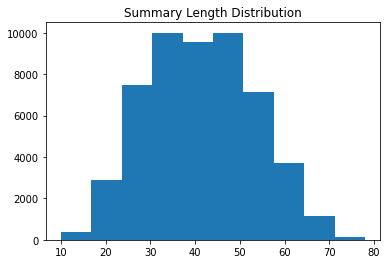

In [ ]:
summary_len = []
for example in train_records:
    summary_ex = example['summary']
    summary_len.append(len(summary_ex.split()))

plt.hist(summary_len)
plt.title('Summary Length Distribution')
plt.show()

In [ ]:
train_dataset = NewsDataset(tokenizer, train_records, 512, 80)

In [192]:
class Trainer:
    def __init__(self, model, tokenizer, train_data, val_data, device, batch_size=4):
        self.model = model.to(device)
        self.tokenizer = tokenizer

        train_data = NewsDataset(self.tokenizer, train_data, 512, 80)
        self.train_dataloader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                                           shuffle=True, num_workers=4)
        
        val_data = NewsDataset(self.tokenizer, val_data, 512, 80)
        self.val_dataloader = DataLoader(val_data, batch_size=batch_size, drop_last=True,
                                           shuffle=True, num_workers=4)
        self.ignore_idx  = self.tokenizer.pad_token_id
        
        # self.criterion = nn.CrossEntropyLoss(ignore_index = self.tokenizer.pad_token_id).to(device)
        self.criterion = nn.NLLLoss(ignore_index = self.ignore_idx)
        self.rouge = Rouge()
        

    def do_epoch(self, data, optimizer=None, name=None):
        epoch_loss = 0
        epoch_rouge_l = 0
        epoch_rouge_1 = 0
        
        is_train = not optimizer is None
        name = name or ''
        model.train(is_train)

        batches_count = len(data)
        
        with torch.autograd.set_grad_enabled(is_train):
            with tqdm(total=batches_count) as progress_bar:
                for batch in data:
                    predictions_ids = model.generate(
                                                batch["source_ids"].to(device),
                                                attention_mask=batch["source_mask"].to(device),
                                                use_cache=True,
                                                decoder_attention_mask=batch['target_mask'].to(device),
                                                max_length=80, 
                                                num_beams=2,
                                                repetition_penalty=2.5, 
                                                length_penalty=1.0, 
                                                early_stopping=True
                                            )

                    # print(f'prediction: {predictions_ids.to(device, dtype = torch.int64).shape}')
                    # print(f'target: {batch["target_ids"].to(device, dtype = torch.int64).shape}')

                    loss = F.nll_loss(predictions_ids.detach().cpu().argmax(dim=1), batch["target_ids"], reduction="none", ignore_index=self.ignore_idx)

                    # loss = self.criterion(predictions_ids.to(device, dtype = torch.float),
                    #                       batch["target_ids"].to(device, dtype = torch.long))
                    
                    predictions = self.ids_to_clean_text(predictions_ids)
                    target = self.ids_to_clean_text(batch["target_ids"])

                    rouge_score = self.rouge.get_score(predictions, target)[0]

                    rouge_1 = rouge_score['rouge-1']['f']
                    rouge_l = touge_score['rouge-l']['f']


                    epoch_loss += loss.item()
                    epoch_rouge_1 += rouge_1
                    epoch_rouge_l += rouge_l

                    if optimizer:
                        optimizer.zero_grad()
                        loss.backward()
                        nn.utils.clip_grad_norm_(model.parameters(), 1)
                        optimizer.step()
                        torch.cuda.empty_cache()
                    
                    progress_bar.update()
                    progress_bar.set_description('{:>5s} Average Loss = {:.5f}, ROUGE-1 = {:.3%}, ROUGE-l = {:.3%}'.format(
                        name, loss.item(), rouge_1, rouge_l))

                progress_bar.set_description('{:>5s} Average Loss = {:.5f}, ROUGE-1 = {:.3%}, ROUGE-l = {:.3%}'.format(
                    name, epoch_loss / batches_count, rouge_1 / batches_count, rouge_l / batches_count ))

        return epoch_loss / batches_count

    def fit(self, epochs_count=1):
        optimizer = AdamW(self.model.parameters(), lr=3e-4, eps=1e-8)
        for epoch in range(epochs_count):
            name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
            train_loss = self.do_epoch(self.train_dataloader, optimizer,
                                name_prefix + 'Train:')

            if not val_data is None:
                val_loss = self.do_epoch(self.val_dataloader, None,
                                            name_prefix + '  Val:')
        

    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)

    @staticmethod
    def lmap(f, x):
        return list(map(f, x))


In [193]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = Trainer(model, tokenizer, train_records, val_records, device, batch_size=4)

In [194]:
trainer.fit(epochs_count=2)

  0%|          | 0/13100 [00:04<?, ?it/s]


ValueError: ignored

### Model

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams        
        self.model = hparams.model_name_or_path
        self.tokenizer = hparams.tokenizer_name_or_path
        self.rouge_metric = Rouge()
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        
        
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.proc_rank <= 0
    
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
    )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
#         rouge: Dict = self.calc_generative_metrics(preds, target)
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        self.rouge_score =  self.rouge_metric.get_scores(preds, target)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)
#         base_metrics.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        # rouge_results = self.rouge_metric.compute()
        # rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=self.rouge_score[0]['rouge-1'], rougeL=self.rouge_score[0]['rouge-l'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : self.rouge_score[0]['rouge-1'],
                "rougeL" : self.rouge_score[0]['rouge-l'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):   
        train_dataset = get_dataset(tokenizer=self.tokenizer, data=self.hparams.train_data, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        validation_dataset = get_dataset(tokenizer=self.tokenizer, data=self.hparams.val_data, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    
    def test_dataloader(self):
        test_dataset = get_dataset(tokenizer=self.tokenizer, data=self.hparams.test_data, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
def get_dataset(tokenizer, data, args):
      return NewsDataset(tokenizer=tokenizer, data=data, input_length=args.max_input_length, 
                        output_length=args.max_output_length)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
train_records = train_records[0:10]

In [ ]:
!mkdir -p t5_news

In [ ]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path=model,
    tokenizer_name_or_path=tokenizer,
    train_data = train_records,
    test_data = val_records,
    val_data = test_records,
    max_input_length=512,
    max_output_length=80,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=4,
    eval_batch_size=4,
    num_train_epochs=2,
    gradient_accumulation_steps=8,
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.05, 
    n_val=1000,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

args_dict.update({'output_dir': 't5_news', 'num_train_epochs':2,
                 'train_batch_size': 4, 'eval_batch_size': 4})
args = argparse.Namespace(**args_dict)

In [ ]:
## Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=3
)

## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    val_check_interval=args.val_check_interval,
    callbacks=[LoggingCallback()],
)

In [ ]:
T5_model = T5FineTuner(args)
trainer = pl.Trainer(**train_params)
trainer.fit(T5_model)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 291 M 


/usr/local/lib/python3.6/dist-packages/transformers/modeling_t5.py:1156: FutureWarning: The `lm_labels` argument is deprecated and will be removed in a future version, use `labels` instead.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


AttributeError: ignored

In [ ]:
hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"

reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)

In [ ]:
scores[0]['rouge-1']

{'f': 0.4786324739396596, 'p': 0.6363636363636364, 'r': 0.3835616438356164}